In [21]:
import sys
import os
import itertools
import textwrap
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from lightgbm import LGBMRegressor
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from autorank import autorank, plot_stats, create_report

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]
targets=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict_w = dict(zip(targets, target_names_w))
target_names_dict = dict(zip(targets, target_names))

In [4]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [5]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[targets]

#### Pair-wise Pearson Correlation

In [6]:
Y_corr=Y.corr('pearson')

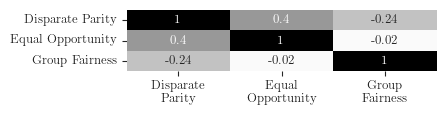

In [ ]:
custom_cmap = LinearSegmentedColormap.from_list("CustomDiverging", ['black', 'white', 'black'])
fig, ax = plt.subplots(figsize=(4, 0.8))
# mask = np.triu(np.ones_like(Y_corr, dtype=bool))
sns.heatmap(Y_corr, cmap=custom_cmap, annot=True,
            yticklabels=[target_names_dict[label] for label in Y_corr.index],
            xticklabels=[target_names_dict_w[label] for label in Y_corr.columns],
            vmin=-1, vmax=1, ax=ax, cbar=False)
plt.xticks(rotation=0, ha='center');
plt.savefig(f"plots/Q3/bias_score_correlation.pdf",bbox_inches="tight")
plt.show()

#### Regression Chains

In [6]:
cv_result_path="experiment_result/Q3_result_3targets.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

In [7]:
def symmetry_mean_aboslute_percentage_error(truth,pred):
    truth=truth.to_numpy()
    pred=pred.to_numpy()
    smape = np.abs(pred - truth) / (np.abs(truth)+np.abs(pred))*2
    output_errors = np.average(smape, axis=0)
    return output_errors

In [8]:
#KFold parameters of the whole cross validation experiments
fold_settings={
    "n_splits":10, 
    "shuffle":True,
    "random_state":420
}
#KFold parameters during Grid Search hyperparmeter tuning
gridCV_settings={
    "n_splits":5,
    "shuffle":True,
    "random_state":1000
}
#KFold parameters during training RegressorChain models
chainCV_settings={
    "n_splits":5,
    "shuffle":True,
    "random_state":1000
}
#Base Parameters of LightGBM
lightGBM_base={
    "objective":"regression", 
    "n_jobs":8, 
    "random_state":700, 
    "device_type":"gpu",
    "verbosity":-1
}
#LGBMRegressor parameters tuned in Grid Search
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[5,10,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}

In [9]:
#Chain sequences are stored in string, so this method help translate sting into list
def parse_target_order(target_chain):
    str_index=[target_chain.find(cc) for cc in targets]
    output=[]
    threshold=-1
    while len(output)<5:
        min_index=min([i for i in str_index if i>threshold])
        output.append(targets[str_index.index(min_index)])
        threshold=min_index
    return output

In [10]:
class EnsembleChain:
    def __init__(self,base_predictors):
        self.base_predictors = base_predictors
    
    def fit(self,X,Y):
        pass
            
    def predict(self, X):
        preds = pd.DataFrame(np.zeros((len(X),len(targets))),columns=targets)
        valid_chain=len(self.base_predictors)
        for target_order,model in self.base_predictors.items():
            chain_pred=model.predict(X)
            if np.isinf(chain_pred).any():
                valid_chain-=1
                continue
            preds += pd.DataFrame(chain_pred,columns=list(target_order))
        return preds / valid_chain

In [ ]:
class EnsembleTree:
    def __init__(self,chains):
        self.chains = chains
        self.model = None
        self.param_grid = {'max_depth': [2, 3, 5, 7, 10, None]}

    def get_chain_preds(self, X):
        chain_predictions = []
        for target_order,model in self.chains.items():
            chain_predictions.append(model.predict(X))
        return np.concatenate(chain_predictions, axis=1)

    def fit(self, X_val, Y_val):
        chain_predictions = self.get_chain_preds(X_val)
        grid_search = GridSearchCV(DecisionTreeRegressor(), self.param_grid, 
                                   cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(chain_predictions, Y_val)
        self.max_depth = grid_search.best_params_['max_depth']
        self.model = DecisionTreeRegressor(max_depth=self.max_depth)
        self.model.fit(chain_predictions, Y_val)
    
    def predict(self, X):
        chain_predictions = self.get_chain_preds(X)
        return pd.DataFrame(self.model.predict(chain_predictions),columns=targets)

In [14]:
def cross_validate_chain(fold_index,
                         train_X, train_Y, valid_X,valid_Y,test_X,test_Y,random_state):
    #target_order=chain_data.iloc[chain_data_index]["target_chain"]
    cv_result=[]
    chain_models={}
    best_parameters={}
    #Initiating KFold instants with parameters
    grid_cv=KFold(**gridCV_settings)
    chain_cv=KFold(**chainCV_settings)
    

    chain_candidataes=[list(perm) for perm in itertools.permutations(targets)]

    for target_order in tqdm(chain_candidataes,total=len(chain_candidataes),desc=f"Regressor Chain {fold_index}"):
        if target_order[0] not in best_parameters:
            gridSearch=GridSearchCV(LGBMRegressor(**lightGBM_base),lightgbm_parameters,cv=grid_cv,n_jobs=5)
            gridSearch.fit(train_X,train_Y[target_order[0]])
            best_param=gridSearch.best_params_
            best_parameters[target_order[0]]=best_param
        else:
            best_param=best_parameters[target_order[0]]
        best_param.update(lightGBM_base)
        best_model=LGBMRegressor(**best_param)
        order=[target_order.index(t) for t in target_order]
        chain_model=RegressorChain(base_estimator=best_model,order=order,random_state=random_state,cv=chain_cv)
        chain_model.fit(train_X,train_Y[target_order])
        chain_models[tuple(target_order)]=chain_model
    
    
    valid_result=[]
    for target_order,model in chain_models.items():
        target_order=list(target_order)
        valid_pred=model.predict(valid_X)
        valid_pred=pd.DataFrame(valid_pred,columns=target_order)
        valid_truth=valid_Y[target_order]
        for target in valid_truth.columns:
            rmse=root_mean_squared_error(valid_truth[target],valid_pred[target])
            valid_result.append({"target_order":tuple(target_order),
                    "label": target,
                    "RMSE":rmse})
    valid_df=pd.DataFrame(valid_result)
    valid_df

    valid_ranking=valid_df.copy()
    for label in targets:
        label_result=valid_ranking[valid_ranking["label"]==label]
        for index,row in label_result["RMSE"].rank().items():
            valid_ranking.at[index,"RMSE"]=row
    valid_ranking

    sum_of_rank=[]
    for to in valid_ranking["target_order"].unique():
        model_ranking=valid_ranking[valid_ranking["target_order"]==to]
        sum_of_rank.append({
            "target_order":to,
            "RMSE rank":model_ranking["RMSE"].sum()
        })
    valid_ranking_sum=pd.DataFrame(sum_of_rank)
    valid_ranking_sum=valid_ranking_sum.sort_values("RMSE rank")
    
    for num in range(2,7):
        model_select=valid_ranking_sum.head(num)["target_order"]
        base_predictors={ to:chain_models[to] for to in chain_models.keys() if any(model_select== to)}
        chain_models[f"AverageEnsemble({num})"]=EnsembleChain(base_predictors)
        ensemble_tree=EnsembleTree(base_predictors)
        ensemble_tree.fit(valid_X,valid_Y[targets])
        chain_models[f"EnsembleTree({num})"]=ensemble_tree

    for name,model in chain_models.items():
        pred=model.predict(test_X)
        if isinstance(model,RegressorChain):
            pred=pd.DataFrame(pred,columns=list(name))
        truth=test_Y[targets]
        for target in truth.columns:
            mae=mean_absolute_error(truth[target],pred[target])
            mse=mean_squared_error(truth[target],pred[target])
            rmse=root_mean_squared_error(truth[target],pred[target])
            mape=mean_absolute_percentage_error(truth[target],pred[target])
            smape=symmetry_mean_aboslute_percentage_error(truth[target],pred[target])
            msle=mean_squared_log_error(np.abs(truth[target]),np.abs(pred[target]))
            cv_result.append({
                "Chain_Model":name,
                "Fold":fold_index,
                "label": target,
                "MAE":mae,
                "MSE":mse,
                "RMSE":rmse,
                "MAPE":mape,
                "SMAPE":smape,
                "MSLE":msle
            })
    result_df=pd.DataFrame(cv_result)
    return result_df

In [15]:
for index,(train_index,test_index) in enumerate(KFold(**fold_settings).split(X,Y)):
    test_X,test_Y=X.iloc[test_index],Y.iloc[test_index]
    train_X,valid_X,train_Y,valid_Y=train_test_split(X.iloc[train_index],Y.iloc[train_index],test_size=0.1,random_state=5000+index*100)
    result_df=cross_validate_chain(index,train_X,train_Y,valid_X,valid_Y,test_X,test_Y,4000)
    cv_result_df=pd.concat([cv_result_df,result_df])
    cv_result_df.to_csv(cv_result_path)

Regressor Chain 0:   0%|          | 0/6 [00:00<?, ?it/s]

Regressor Chain 9: 100%|██████████| 6/6 [23:55<00:00, 239.28s/it]


In [36]:
cv_result_df

,Chain_Model,Fold,label,MAE,MSE,RMSE,MAPE,SMAPE,MSLE
480,LightGBM(DEG),0,disparate_parity,0.097266,0.017952,0.133985,1.493166e+12,0.705574,0.011223
481,LightGBM(DEG),0,equal_opportunity,0.113952,0.028494,0.168800,2.696815e+12,0.743629,0.016211
482,LightGBM(DEG),0,group_fairness,0.076642,0.015306,0.123716,2.216400e-01,0.191025,0.004425
483,LightGBM(DGE),0,disparate_parity,0.097266,0.017952,0.133985,1.493166e+12,0.705574,0.011223
484,LightGBM(DGE),0,equal_opportunity,0.114245,0.028669,0.169320,2.751891e+12,0.744587,0.016324
...,...,...,...,...,...,...,...,...,...
955,AverageEnsemble(6),9,equal_opportunity,0.104730,0.024963,0.157996,1.372239e+12,0.716560,0.014404
956,AverageEnsemble(6),9,group_fairness,0.051099,0.007095,0.084231,1.634604e-01,0.141678,0.002129
957,EnsembleTree(6),9,disparate_parity,0.102692,0.019142,0.138356,1.582941e+12,0.744582,0.012095
958,EnsembleTree(6),9,equal_opportunity,0.113810,0.028150,0.167779,1.848513e+12,0.766723,0.016356


In [37]:
def shorten_target_order(target_order_tuple):
    output=""
    for target in target_order_tuple:
        output+=target[0].capitalize()
    return output

In [11]:
cv_result_df=cv_result_df.reset_index(drop=True)
model_names=[]
for model in cv_result_df["Chain_Model"]:
    if isinstance(model,tuple):
        model=f"LightGBM({shorten_target_order(model)})"
    model_names.append(model)
cv_result_df["Chain_Model"]=pd.Series(model_names,name="Chain_Model")
cv_result_df.to_csv(cv_result_path)
cv_result_df

,Chain_Model,Fold,label,MAE,MSE,RMSE,MAPE,SMAPE,MSLE
0,LightGBM(DEG),0,disparate_parity,0.097266,0.017952,0.133985,1.493166e+12,0.705574,0.011223
1,LightGBM(DEG),0,equal_opportunity,0.113952,0.028494,0.168800,2.696815e+12,0.743629,0.016211
2,LightGBM(DEG),0,group_fairness,0.076642,0.015306,0.123716,2.216400e-01,0.191025,0.004425
3,LightGBM(DGE),0,disparate_parity,0.097266,0.017952,0.133985,1.493166e+12,0.705574,0.011223
4,LightGBM(DGE),0,equal_opportunity,0.114245,0.028669,0.169320,2.751891e+12,0.744587,0.016324
...,...,...,...,...,...,...,...,...,...
475,AverageEnsemble(6),9,equal_opportunity,0.104730,0.024963,0.157996,1.372239e+12,0.716560,0.014404
476,AverageEnsemble(6),9,group_fairness,0.051099,0.007095,0.084231,1.634604e-01,0.141678,0.002129
477,EnsembleTree(6),9,disparate_parity,0.102692,0.019142,0.138356,1.582941e+12,0.744582,0.012095
478,EnsembleTree(6),9,equal_opportunity,0.113810,0.028150,0.167779,1.848513e+12,0.766723,0.016356


In [39]:
#Calculate the average of chain models' result
def get_average_result(result_df):
    average_df=[]
    for model in result_df["Chain_Model"].unique():
        model_df=result_df[result_df["Chain_Model"]==model]
        for label in targets:
            label_df=model_df[model_df["label"]==label][["MAE","MSE","RMSE","MAPE","SMAPE","MSLE"]]
            label_average=label_df.sum()/len(label_df)
            average_df.append({
                "Chain_Model":model,
                "label":label,
                "MAE":label_average["MAE"],
                "MSE":label_average["MSE"],
                "RMSE":label_average["RMSE"],
                "MAPE":label_average["MAPE"],
                "SMAPE":label_average["SMAPE"],
                "MSLE":label_average["MSLE"]
            })
    return pd.DataFrame(average_df)

In [40]:
average_df=get_average_result(cv_result_df)
average_df.to_csv("experiment_result/Q3_average_3targets.csv")
average_df=average_df.drop(["MAE","MSE","MAPE","SMAPE","MSLE"],axis=1)
average_df

,Chain_Model,label,RMSE
0,LightGBM(DEG),disparate_parity,0.129010
1,LightGBM(DEG),equal_opportunity,0.160818
2,LightGBM(DEG),group_fairness,0.120547
3,LightGBM(DGE),disparate_parity,0.129010
4,LightGBM(DGE),equal_opportunity,0.160672
5,LightGBM(DGE),group_fairness,0.120734
6,LightGBM(EDG),disparate_parity,0.129120
7,LightGBM(EDG),equal_opportunity,0.159054
8,LightGBM(EDG),group_fairness,0.103694
9,LightGBM(EGD),disparate_parity,0.129145


In [41]:
#Insert average result of individual predictors
individual_average_df=pd.read_csv("experiment_result/Q2_average_result.csv",index_col=0)
individual_average_df=individual_average_df[individual_average_df["Model"]=="LightGBM"][individual_average_df["label"].isin(targets)][["Model","label","RMSE"]]
individual_average_df=individual_average_df.rename(columns={'Model': 'Chain_Model'})
average_df=pd.concat([individual_average_df,average_df],ignore_index=True)
average_df

,Chain_Model,label,RMSE
0,LightGBM,equal_opportunity,0.157528
1,LightGBM,disparate_parity,0.128959
2,LightGBM,group_fairness,0.073563
3,LightGBM(DEG),disparate_parity,0.129010
4,LightGBM(DEG),equal_opportunity,0.160818
5,LightGBM(DEG),group_fairness,0.120547
6,LightGBM(DGE),disparate_parity,0.129010
7,LightGBM(DGE),equal_opportunity,0.160672
8,LightGBM(DGE),group_fairness,0.120734
9,LightGBM(EDG),disparate_parity,0.129120


In [42]:
#Calculate the rank of chain models on all metrics
rank_df=average_df.copy()
for label in targets:
    label_result=average_df[average_df["label"]==label]
    for index,row in label_result["RMSE"].rank().items():
        rank_df.at[index,"RMSE"]=row

rank_df

,Chain_Model,label,RMSE
0,LightGBM,equal_opportunity,1.0
1,LightGBM,disparate_parity,4.0
2,LightGBM,group_fairness,1.0
3,LightGBM(DEG),disparate_parity,5.0
4,LightGBM(DEG),equal_opportunity,10.0
5,LightGBM(DEG),group_fairness,16.0
6,LightGBM(DGE),disparate_parity,6.0
7,LightGBM(DGE),equal_opportunity,9.0
8,LightGBM(DGE),group_fairness,17.0
9,LightGBM(EDG),disparate_parity,8.0


In [43]:
#Obtain the aggregated rank of all chain models
sum_of_rank=[]
for to in rank_df["Chain_Model"].unique():
    model_percentile_df=rank_df[rank_df["Chain_Model"]==to]
    sum_of_rank.append({
        "Chain_Model":to,
        "RMSE rank":model_percentile_df["RMSE"].sum()
    })
sum_of_rank_df=pd.DataFrame(sum_of_rank)
sum_of_rank_df=sum_of_rank_df.sort_values("RMSE rank")
sum_of_rank_df.to_csv("experiment_result/Q3_chain_ranking_3targets.csv")
sum_of_rank_df

,Chain_Model,RMSE rank
0,LightGBM,6.0
13,AverageEnsemble(5),13.0
15,AverageEnsemble(6),17.0
9,AverageEnsemble(3),19.0
11,AverageEnsemble(4),20.0
7,AverageEnsemble(2),22.0
3,LightGBM(EDG),25.0
4,LightGBM(EGD),26.0
1,LightGBM(DEG),31.0
6,LightGBM(GED),31.0


In [ ]:
#Produce the graph for individual chain models in stage 2 experiment
def display_full_result(df,x,metrics,save_path=""):
    g=sns.FacetGrid(df, col="label", col_wrap=3,sharey=False,sharex=False, height=2.5, aspect= 1)
    g.map_dataframe(sns.barplot,x=x,y=metrics,estimator="mean", palette=sns.color_palette("Paired"))
    for ax, (_, subdata) in zip(g.axes.flat, g.facet_data()):
        label=subdata["label"].unique()[0]
        range_min,range_max=subdata[metrics].min(),subdata[metrics].max()
        new_ylim = (range_min, range_max)
        ax.set_ylim(new_ylim)
        ax.set(xticklabels=[])
        ax.set_title(label,fontsize="xx-large")
        ax.axhline(y=individual_average_df[individual_average_df["label"]==label][metrics].iloc[0], color='r', linestyle='-')
    plt.legend(ax.patches,df[x].unique(),loc='lower center',bbox_to_anchor=(-1, -1), title=x,
                borderpad=0.2,handlelength=1, 
                fontsize="large",title_fontsize="xx-large", ncol=3,columnspacing=0.4,handletextpad=0.4)
    if save_path!="":
        plt.savefig(f"plots/Q3/{save_path}.pdf",bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


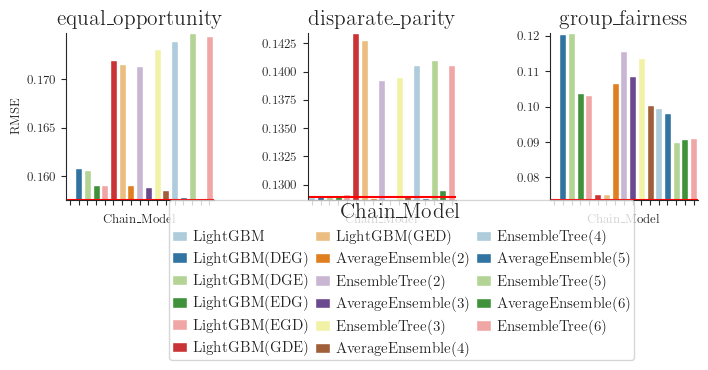

In [45]:
display_full_result(average_df,"Chain_Model","RMSE","RMSE_3targets")

#### Quality of Chains

In [26]:
def plot_rank_to_metric(metric):
    cv_result_df = pd.read_csv(cv_result_path, index_col=0)
    cv_result_df = cv_result_df[cv_result_df['label'].isin(targets)]
    cv_result_df = cv_result_df[cv_result_df['Chain_Model'].str.startswith('LightGBM')]
    cv_result_df['label'] = cv_result_df['label'].replace(target_names_dict)

    plt.figure(figsize=(2, 1.5))
    for i, target in enumerate(np.append('All', cv_result_df['label'].unique())):
        if target != 'All':
            avg_result_df = cv_result_df[cv_result_df['label'] == target]
        else:
            avg_result_df = cv_result_df
        avg_result_df = avg_result_df.groupby('Chain_Model', as_index=False)['RMSE'].mean()
        avg_result_df = avg_result_df.sort_values('RMSE', ascending=True)
        avg_result_df['rank'] = range(1, len(avg_result_df) + 1)

        plt.plot(avg_result_df['rank'], avg_result_df[metric], marker=None, 
                 color=COLORS[i], label=target)
    plt.xlabel('Rank of Chain')
    plt.ylabel(metric)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.savefig('plots/Q3/Q3_regression_chain_rank_to_rmse.pdf', bbox_inches='tight')
    plt.show()

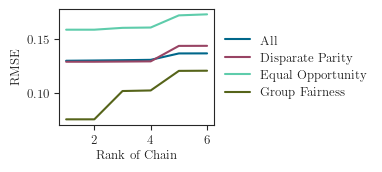

In [27]:
plot_rank_to_metric('RMSE')

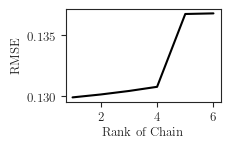

In [ ]:
cv_result_df = pd.read_csv(cv_result_path, index_col=0)
cv_result_df = cv_result_df[cv_result_df['Chain_Model'].str.startswith('LightGBM')]
cv_result_df['label'] = cv_result_df['label'].replace(target_names_dict)

plt.figure(figsize=(2, 1.2))
avg_result_df = cv_result_df.groupby('Chain_Model', as_index=False)['RMSE'].mean()
avg_result_df = avg_result_df.sort_values('RMSE', ascending=True)
avg_result_df['rank'] = range(1, len(avg_result_df) + 1)

plt.plot(avg_result_df['rank'], avg_result_df['RMSE'], marker=None, color='black')
plt.xlabel('Rank of Chain')
plt.ylabel('RMSE')
plt.savefig("plots/Q3/regression_chain_3targets_rank.pdf",bbox_inches="tight")
plt.show()

### Comparison Single-Target vs. Multi-Target

In [38]:
lightgbm_parameters={
    "n_estimators":[50,100,150,200,250,300,400,500,750],
    "max_depth":[2,3,5,7,10,15],
    "learning_rate":[0.1],
}

In [39]:
class CVLightGBM:
    def __init__(self):
        self.best_params = {}

    def fit(self, X, y, **kwargs):
        base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="cpu",verbosity=-1)
        self.model=GridSearchCV(base_model, param_grid=lightgbm_parameters, cv=KFold(n_splits=3, shuffle=True, random_state=700), 
                                scoring="neg_root_mean_squared_error", n_jobs=5)
        self.model.fit(X, y)
        self.best_params = self.model.best_params_

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=False):
        return self.best_params

In [40]:
class AveragingModel:
    def __init__(self, index):
        self.chains = []
        self.orders = []
        for i, order in enumerate(itertools.permutations(range(len(targets)))):
            with open(f"experiment_result/Q3_models/chain_models_{index}_{i}.pkl", "rb") as file:
                _, model = pickle.load(file)
            self.chains.append(model)
            self.orders.append(order)

    def fit(self, X_val, Y_val):
        pass
    
    def predict(self, X):
        preds = []
        for model in self.chains:
            preds.append(model.predict(X))
        return np.average(np.array(preds), axis=0)

In [43]:
# results = []
# for index,(tr,te) in enumerate(KFold(**fold_settings).split(X,Y)):
#     X_test, Y_test = X.iloc[te],Y.iloc[te]
#     X_train, X_val, Y_train, Y_val = train_test_split(X.iloc[tr], Y.iloc[tr], test_size=0.1, random_state=5000+index*100)

#     # train chains
#     for i, order in enumerate(list(itertools.permutations(range(len(targets))))):
#         chain = [targets[i] for i in order]
#         chain_model=RegressorChain(base_estimator=CVLightGBM(), order=order, random_state=1000)
#         chain_model.fit(X_train, Y_train)       
#         with open(f"experiment_result/Q3_models/chain_models_{index}_{i}.pkl","wb") as file:
#             pickle.dump((chain,chain_model),file)
#         res = {'Fold': index, 'Model': 'Chain', 'Chain': chain, 'RMSE': root_mean_squared_error(Y_test, chain_model.predict(X_test))}
#         results.append(res)
#         print(res)
        
#     model_avg = AveragingModel(index)
#     model_avg.fit(X_val, Y_val)
#     res = {'Fold': index, 'Model': 'Ensemble', 'Chain': None, 'RMSE': root_mean_squared_error(Y_test, model_avg.predict(X_test))}
#     results.append(res)
#     print(res)
    
#     pd.DataFrame(results).to_csv('experiment_result/Q3_chain_ensemble_minimal.csv', index=False)

In [149]:
# # get RMSE per target
# results = []
# for index,(tr,te) in enumerate(KFold(**fold_settings).split(X,Y)):
#     X_test, Y_test = X.iloc[te],Y.iloc[te]
#     X_train, X_val, Y_train, Y_val = train_test_split(X.iloc[tr], Y.iloc[tr], test_size=0.1, random_state=5000+index*100)

#     # train chains
#     for i, order in enumerate(list(itertools.permutations(range(len(targets))))):
#         chain = [targets[i] for i in order]
#         with open(f"experiment_result/Q3_models/chain_models_{index}_{i}.pkl", "rb") as file:
#             _, model = pickle.load(file)
#         for t, target in enumerate(targets):
#             res = {'Fold': index, 'Model': 'Chain', 'Chain': chain, 'Target': target,
#                    'RMSE': root_mean_squared_error(Y_test[target], model.predict(X_test)[:,t])}
#             results.append(res)
        
#     model_avg = AveragingModel(index)
#     model_avg.fit(X_val, Y_val)
#     for t, target in enumerate(targets):
#         res = {'Fold': index, 'Model': 'Ensemble', 'Chain': None, 'Target': target,
#                'RMSE': root_mean_squared_error(Y_test[target], model_avg.predict(X_test)[:,t])}
#         results.append(res)
    
#     pd.DataFrame(results).to_csv('experiment_result/Q3_chain_ensemble_minimal.csv', index=False)

In [150]:
df_results = pd.read_csv('experiment_result/Q3_chain_ensemble_minimal.csv')
df_results = df_results.rename({'Target': 'label'}, axis=1)

In [151]:
df_ensemble = df_results[df_results["Model"] == "Ensemble"]
df_chain_best = df_results[df_results["Model"] == "Chain"].loc[
    df_results[df_results["Model"] == "Chain"].groupby(["Fold", "label"])["RMSE"].idxmin()
]
df_chain_best['Model'] = 'BestChain'
df_multi = pd.concat([df_chain_best, df_ensemble])

In [152]:
df_single = pd.read_csv("experiment_result/Q2_result.csv", index_col=0)
df_single = df_single[['Model', 'Fold', 'label', 'RMSE']]
df_single = df_single[df_single['Model'].isin(['NaiveMean', 'LinearRegression', 'Lasso', 'XGBoost',
       'LightGBM', 'RandomForest', 'MLP'])]
df_single = df_single[df_single['label'].isin(targets)]
# df_single_avg = df_single.groupby(by=['Model', 'Fold'])['RMSE'].mean().reset_index()

In [153]:
# df_concat = pd.concat([df_single_avg, df_multi.drop(['Chain'], axis=1)]).reset_index(drop=True)
df_concat = pd.concat([df_single, df_multi.drop(['Chain'], axis=1)]).reset_index(drop=True)
df_piv = df_concat.pivot(index=['Fold', 'label'], columns='Model', values='RMSE')

In [154]:
result = autorank(-df_piv, alpha=0.01)
# result = autorank(-pd.concat([df_piv, df_piv]).reset_index().drop(['Fold'], axis=1), alpha=0.01)

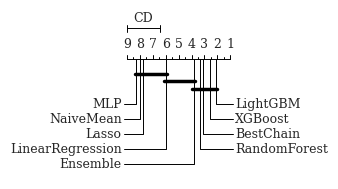

In [ ]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(2,2.2))
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_stats(result, ax=ax)
plt.savefig('Plots/Q3/single_and_ensemble_CD_plot.pdf', bbox_inches='tight')
plt.show()

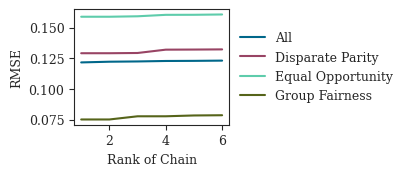

In [156]:
df_results = pd.read_csv('experiment_result/Q3_chain_ensemble_minimal.csv')
df_results = df_results[df_results['Model'] == 'Chain']
df_results['Target'] = df_results['Target'].replace(target_names_dict)

plt.figure(figsize=(2, 1.5))
for i, target in enumerate(np.append('All', df_results['Target'].unique())):
    if target != 'All':
        avg_result_df = df_results[df_results['Target'] == target]
    else:
        avg_result_df = df_results
    avg_result_df = avg_result_df.groupby('Chain', as_index=False)['RMSE'].mean()
    avg_result_df = avg_result_df.sort_values('RMSE', ascending=True)
    avg_result_df['rank'] = range(1, len(avg_result_df) + 1)

    plt.plot(avg_result_df['rank'], avg_result_df['RMSE'], marker=None, 
                color=COLORS[i], label=target)
plt.xlabel('Rank of Chain')
plt.ylabel('RMSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.savefig('plots/Q3/Q3_regression_chain_rank_to_rmse.pdf', bbox_inches='tight')
plt.show()